In [2]:
import scipy.optimize
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

NameError: name 'з' is not defined

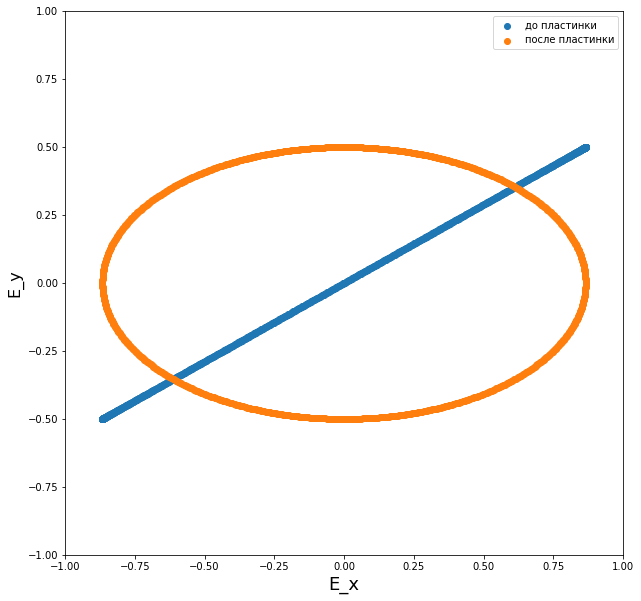

In [30]:
t = np.linspace(start=0, stop=np.pi * 2, num=1000)
alpha = 30 / 180 * np.pi
plt.figure(figsize=(10, 10))
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.xlabel('E_x', fontsize=18)
plt.ylabel('E_y', fontsize=16)
plt.scatter(np.sin(t) * np.cos(alpha), np.sin(t) * np.sin(alpha), label='до пластинки')
plt.scatter(np.sin(t) * np.cos(alpha), np.sin(t + np.pi / 2) * np.sin(alpha), label='после пластинки')
plt.legend()
з
plt.show()

In [40]:
data = pd.read_csv('data.csv')
data['psi_up'] = data['180 + psi (up)'] - 180
data['psi_down'] = data['180 + psi (down)'] - 180
data['phi_1'] = data['2 phi_1'] / 2
data.head()

,2 phi_1,180 + psi (up),180 + psi (down),psi_up,psi_down,phi_1
0,0,NaN,207,NaN,27,0.0
1,4,222.0,205,42.0,25,2.0
2,10,216.0,203,36.0,23,5.0
3,15,214.0,202,34.0,22,7.5
4,20,212.0,202,32.0,22,10.0


$\varphi_2 = \psi + A - \varphi_1$

$\sin\varphi_1 = n \sin\beta_1$

$\sin\varphi_2 = n \sin\beta_2$

$\beta_1+\beta_2=A$

In [132]:
def get_error_function(phi_1, psi, A):
    A *= np.pi / 180
    phi_1 *= np.pi / 180
    psi *= np.pi / 180
    
    phi_2 = psi + A - phi_1
    
    def error_function(n):
        beta_1 = np.arcsin(np.sin(phi_1) / n)
        beta_2 = np.arcsin(np.sin(phi_2) / n)
        return beta_1 + beta_2 - A
    
    return error_function

def solve_n(phi_1, psi, A):
    if np.isnan(psi):
        return np.nan
    else:
        return scipy.optimize.newton_krylov(get_error_function(phi_1, psi, A), 1.55, f_tol=1e-12)

In [163]:
A = 38
EPSILON = 1e-4

for direction in ['up', 'down']:
    data[f'n_{direction}']   = data.apply(lambda x: solve_n(x['phi_1'], x[f'psi_{direction}'], A), axis=1)
    data[f'd_phi_1_n_{direction}'] = (data.apply(lambda x: solve_n(x['phi_1'] + EPSILON, x[f'psi_{direction}'], A), axis=1)
                            - data[f'n_{direction}']) / EPSILON
    data[f'd_psi_{direction}_n_{direction}'] = (data.apply(lambda x: solve_n(x['phi_1'], x[f'psi_{direction}'] + EPSILON, A), axis=1)
                            - data[f'n_{direction}']) / EPSILON
# data['n_down'] = data.apply(lambda x: solve_n(x['phi_1'], x['psi_down'], A), axis=1)?

In [167]:
data.head()

,2 phi_1,180 + psi (up),180 + psi (down),psi_up,psi_down,phi_1,n_up,n_down,d_phi_1_n_up,d_psi_up_n_up,d_phi_1_n_down,d_psi_down_n_down,d_n_up,d_n_down
0,0,NaN,207,NaN,27,0.0,NaN,1.4720878654251548,NaN,NaN,0.010358,0.011981,NaN,0.006526
1,4,222.0,205,42.0,25,2.0,1.6338171657506195,1.4657027612497904,0.0168,0.005893,0.008995,0.01374,0.00513,0.007229
2,10,216.0,203,36.0,23,5.0,1.6302716165885203,1.460736914077035,0.013007,0.010145,0.007428,0.015824,0.006025,0.008127
3,15,214.0,202,34.0,22,7.5,1.638315278791174,1.4615255361743935,0.011291,0.012166,0.006416,0.017189,0.006706,0.008743
4,20,212.0,202,32.0,22,10.0,1.6381475555273026,1.4767668581762747,0.009603,0.014095,0.005772,0.018096,0.007445,0.009162


In [166]:
d_angle = 0.5
d_phi_1 = d_angle / 2

for direction in ['up', 'down']:
    data[f'd_n_{direction}'] = ((data[f'd_phi_1_n_{direction}'] * d_phi_1) ** 2 + 
    (data[f'd_psi_{direction}_n_{direction}'] * d_angle) ** 2) ** 0.5

In [192]:
data['cos2_theta_down'] = (np.sin(data.phi_1 / 180 * np.pi) / data.n_down) ** 2
data['d_cos2_theta_down'] = data['cos2_theta_down'] * (
    np.abs(np.cos(data.phi_1 / 180 * np.pi) * d_phi_1 / 180 * np.pi / np.sin(data.phi_1 / 180 * np.pi)) +
    np.abs(data.d_n_down / data.n_down)) * 2

data['cos2_theta_up'] = (np.sin(data.phi_1 / 180 * np.pi) / data.n_up) ** 2
data['d_cos2_theta_up'] = data['cos2_theta_up'] * (
    np.abs(np.cos(data.phi_1 / 180 * np.pi) * d_phi_1 / 180 * np.pi / np.sin(data.phi_1 / 180 * np.pi)) +
    np.abs(data.d_n_up / data.n_up)) * 2

data['d_cos2_theta_up'] = data['d_cos2_theta_up'].fillna(0)
data['d_cos2_theta_down'] = data['d_cos2_theta_down'].fillna(0)

data.head(1)

,2 phi_1,180 + psi (up),180 + psi (down),psi_up,psi_down,phi_1,n_up,n_down,d_phi_1_n_up,d_psi_up_n_up,d_phi_1_n_down,d_psi_down_n_down,d_n_up,d_n_down,cos2_theta_down,cos2_theta_up,d_cos2_theta_down,d_cos2_theta_up
0,0,NaN,207,NaN,27,0.0,NaN,1.4720878654251548,NaN,NaN,0.010358,0.011981,NaN,0.006526,0.0,NaN,0.0,0.0


In [199]:
data[['cos2_theta_down', 'd_cos2_theta_down', 'n_down', 'd_n_down']].to_csv('down.data', sep=' ', header=False, index=False)
data[['cos2_theta_up', 'd_cos2_theta_up', 'n_up', 'd_n_up']].to_csv('up.data', sep=' ', header=False, index=False)

In [215]:
np.sin((data.psi_up.min() + A + 1) / 2 / 180 * np.pi) / np.sin((A + 0.5) / 2 / 180 * np.pi)

1.651969938609906

In [204]:
data.psi_up.min()

27.0

In [226]:
phi = -4.75 / 180 * np.pi
A2 = A - 1
1/np.sin(A2 / 180 * np.pi) * (np.sin(phi) ** 2 + 1 + 2 * np.cos(A2 / 180 * np.pi) * np.sin(phi))

1.4532539326875475

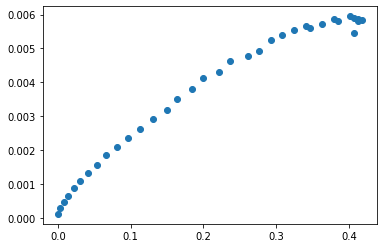

In [187]:
# plt.scatter((np.sin(data.phi_1 / 180 * np.pi) / data.n_down) ** 2, data.n_down)
plt.scatter((np.sin(data.phi_1 / 180 * np.pi) / data.n_down) ** 2, data.d_cos2_theta_up)
plt.show()